# ANN-Based Demodulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [2]:
def demapper_sym(symbols_I, symbols_Q, Ns, threshold=2.0):
    symbol = []
    for i in range(Ns):
        if symbols_I[i] <= -threshold and symbols_Q[i] >= threshold:  # -3+3j
            symbol.append(0)
        elif symbols_I[i] <= -threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold:  # -3+1j
            symbol.append(1)
        elif symbols_I[i] <= -threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold:  # -3-j
            symbol.append(3)
        elif symbols_I[i] <= -threshold and symbols_Q[i] <= -threshold:  # -3-3j
            symbol.append(2)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] >= threshold:  # -1+3j
            symbol.append(4)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold:  # -1+j
            symbol.append(5)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold:  # -1-j
            symbol.append(7)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] <= -threshold:  # -1-3j
            symbol.append(6)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] >= threshold:  # 1+3j
            symbol.append(12)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold:  # 1+j
            symbol.append(13)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold:  # 1-j
            symbol.append(15)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] <= -threshold:  # 1-3j
            symbol.append(14)
        elif symbols_I[i] >= threshold and symbols_Q[i] >= threshold:  # 3+3j
            symbol.append(8)
        elif symbols_I[i] >= threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold:  # 3+1j
            symbol.append(9)
        elif symbols_I[i] >= threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold:  # 3-1j
            symbol.append(11)
        elif symbols_I[i] >= threshold and symbols_Q[i] <= -threshold:  # 3-3j
            symbol.append(10)
    return np.array(symbol)


def bit_error_rate(y_test, y_pred):
    test = ''.join([f"{sym:04b}" for sym in y_test])
    pred = ''.join([f"{sym:04b}" for sym in y_pred])

    test = np.array(list(test))
    pred = np.array(list(pred))

    # Calculate the BER with the two strings
    ber = 0
    for i, j in zip(test, pred):
        if i != j:
            ber += 1

    return ber/len(test)


def add_noise(signal, target_snr_db):
    X_avg_p = np.mean(signal**2)
    X_avg_db = 10 * np.log10(X_avg_p)
    noise_avg_db_r = X_avg_db - target_snr_db
    noise_avg_p_r = 10 ** (noise_avg_db_r / 10)
    mean_noise = 0
    noise_r = np.random.normal(mean_noise, np.sqrt(noise_avg_p_r), len(signal))
    return noise_r + signal


## Preparing Dataset

In [3]:
np.random.seed(0)
Ns = 10000
n = 16
y = np.random.randint(n, size=Ns)


In [4]:
mod_dict = np.array([
    [-3, 3], [-3, 1], [-3, -3], [-3, -1],
    [-1, 3], [-1, 1], [-1, -3], [-1, -1],
    [3, 3], [3, 1], [3, -3], [3, -1],
    [1, 3], [1, 1], [1, -3], [1, -1]
])

signal = mod_dict[y]


In [5]:
OSNR = [10, 11, 12, 13, 14, 15, 16, 17]
Xr = [add_noise(signal[:, 0], it) for it in OSNR]
Xi = [add_noise(signal[:, 1], it) for it in OSNR]


In [6]:
X = [np.array([Xr[i], Xi[i]]).T for i in range(len(OSNR))]


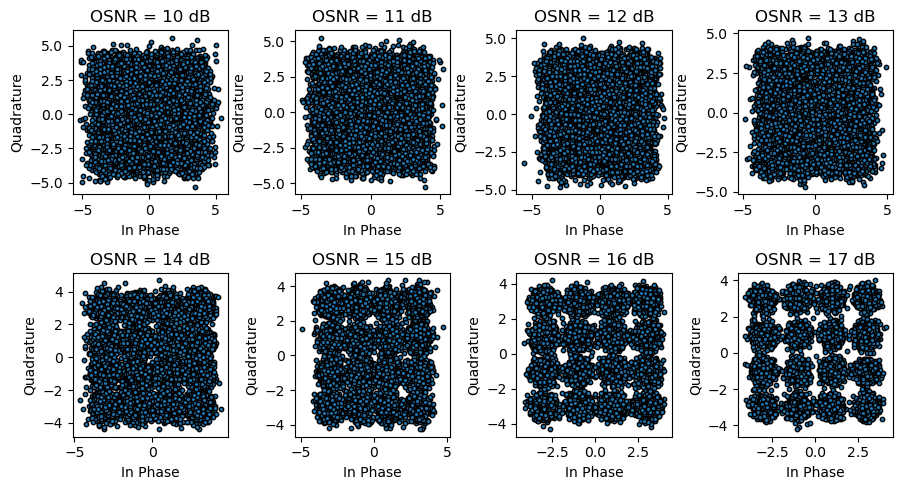

In [7]:
plt.figure(figsize=(9, 5))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.scatter(Xr[i], Xi[i], s=10, edgecolors='black')
    plt.title('OSNR = %d dB' % (OSNR[i]))
    plt.xlabel('In Phase')
    plt.ylabel('Quadrature')
plt.tight_layout()
plt.show()


## Conventional Demodulation

In [8]:
ber_conv = []
for i in range(len(OSNR)):
    X_train, X_test, y_train, y_test = train_test_split(
        X[i], y, test_size=0.2, random_state=42)

    syms_dem = demapper_sym(X_test[:, 0], X_test[:, 1], len(X_test))
    ber = bit_error_rate(y_test, syms_dem)
    ber_conv.append(ber)


## ANN Demodulation

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(n, activation='sigmoid'),
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

ber_ann = []
for i in range(len(OSNR)):
    X_train, X_test, y_train, y_test = train_test_split(
        X[i], y, test_size=0.2, random_state=42)

    model.fit(
        X_train,
        y_train,
        batch_size=64,
        epochs=10
    )

    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    ber = bit_error_rate(y_test, y_pred)
    ber_ann.append(ber)


Epoch 1/10
125/125 [==============================] - 1s 2ms/step - loss: 1.8910 - accuracy: 0.4094
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 1.1547 - accuracy: 0.6173
Epoch 3/10
125/125 [==============================] - 0s 2ms/step - loss: 0.9289 - accuracy: 0.6954
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.7924 - accuracy: 0.7370
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.7059 - accuracy: 0.7586
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 0.6596 - accuracy: 0.7639
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss: 0.6320 - accuracy: 0.7686
Epoch 8/10
125/125 [==============================] - 0s 1ms/step - loss: 0.6154 - accuracy: 0.7700
Epoch 9/10
125/125 [==============================] - 0s 1ms/step - loss: 0.6037 - accuracy: 0.7721
Epoch 10/10
63/63 [==============================] - 0s 1ms/step
Epoch 1/10
125/125 [===============

## Show the Graphics

In [10]:
def fit_curve(x, y, x_step, deg=2):
    p = np.polyfit(x, y, deg)
    z = np.poly1d(p)
    curve = z(x_step)
    return curve


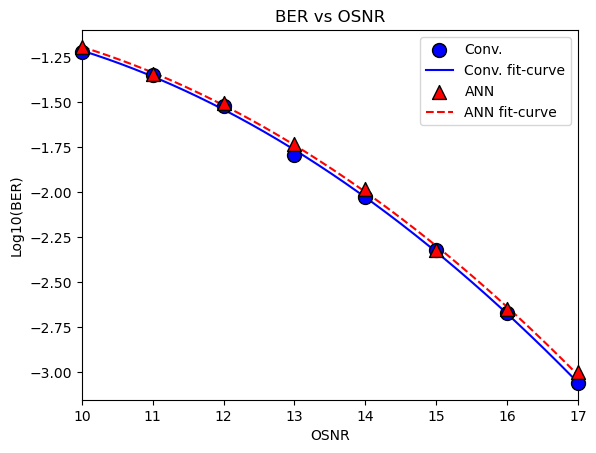

In [11]:
X_step = np.linspace(np.min(OSNR), np.max(OSNR), 1000)

# Show figure of BER vs scale factor
plt.scatter(OSNR, np.log10(ber_conv), label='Conv.',
            color='blue', marker='o', s=100, edgecolors='black',
            zorder=3, clip_on=False)
plt.plot(X_step, fit_curve(OSNR, np.log10(ber_conv), X_step), '-',
         color='blue', label='Conv. fit-curve')

plt.scatter(OSNR, np.log10(ber_ann), label='ANN',
            color='red', marker='^', s=100, edgecolors='black',
            zorder=3, clip_on=False)
plt.plot(X_step, fit_curve(OSNR, np.log10(ber_ann), X_step), '--',
         color='red', label='ANN fit-curve')

plt.xlabel('OSNR')
plt.ylabel('Log10(BER)')
plt.title('BER vs OSNR')
plt.xlim([np.min(OSNR), np.max(OSNR)])
plt.legend()
plt.show()
